<a href="https://colab.research.google.com/github/SammyGIS/GIS-notebooks/blob/main/Image_Processing_and_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Data Analysis in Python


## Aim
The aim of this coursework is for you to put your Python programming skills for satellite data analysis into practice and apply them to an environmental problem. Write a Python program to download and process Sentinel-2 satellite images to answer ONE of the specified questions:


### Question
Mapping fire damage from the Dixie fire in California in 2021 using Sentinel-2 Normalised Burn Ratio (NBR) and differenced NBR Obtain an image from Sentinel-2 before and one after the Dixie fire. 

* Calculate NBR from each image and dNBR from both images. 
* Produce a map of the areas where the fire damage has been greatest. 
* Calculate the average NBR1, NBR2 and dNBR for a selection of burned and unburned polygons you draw in a GIS. 
* Make maps of NDVI before and after the fire as well.
* Calculate the NDVI difference and test whether dNBR was correlated to a loss in NDVI.
* Was the Dixie fire uniform or did it affect some areas in different ways?

#### About Dixies Fire in California 2021

The Dixie Fire was an enormous wildfire in Butte, Plumas, Lassen, Shasta, and Tehama Counties, California. It is named after the creek near where it started. The fire began in the Feather River Canyon near Cresta Dam on July 13, 2021, and burned 963,309 acres (389,837 ha) before being 100% contained on October 25, 2021. It was the largest single (i.e. non-complex) wildfire in recorded California history, and the second-largest wildfire overall (after the August Complex fire of 2020). The fire damaged or destroyed several small towns, including Greenville on August 4, Canyondam on August 5, and Warner Valley on August 12.

By July 23, it had become the largest wildfire of the 2021 California fire season; by August 6, it had grown to become the largest single (i.e. non-complex) wildfire in the state's history, burning an area larger than the state of Rhode Island. It was the first fire known to have burned across the crest of the Sierra Nevada (followed by the Caldor Fire later in the season). Smoke from the Dixie Fire caused unhealthy air quality across the Western United States, including states as far east as Utah and Colorado.

Date(s)	July 13, 2021 — October 25, 2021.

**source: https://en.wikipedia.org/wiki/Dixie_Fire

## Install, Import, authenticate and Initialiaze the neccessary libaries

In [127]:
# install neccessary libaries 
!pip install geemap
!pip install geopandas
!pip install seaborn
!pip install matplotlib



# Import the necessary libraries
import ee
import numpy as np
import geemap.eefolium as geemap # the imagery diplay will be disaply on a basemap
import geopandas as gpd # use to load shapefiles
import pprint
import seaborn as sns # used for visualization of chart
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

#### Activate Google Earth Engine

In [128]:
# Authenticate and initialize this instance of google eateh enigne in this notebook
# Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=5C-LgRq20H98fGA1jgACXqTUJxKxr94I1_BwueOzIek&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhBNA1_o9mumvQRviWblKVaNJYlbOAdKBF5tEG7CPQe3tYQuhd1AHI

Successfully saved authorization token.


## Data Collection, FIltering and Preprocessing

In [129]:
# Create a center point at location where the fire happend, the point was collect from https://www.fire.ca.gov/incidents/2021/7/14/dixie-fire/
point = ee.Geometry.Point([-121.389439,39.871306])

In [130]:
# Colection of sentinel Imagery from the Sentinel-2 data
# Create and filter sentinel 2 image by bounds dates and cloud cover
# Pre-filter to get less cloudy granules
dataset=  ee.ImageCollection("COPERNICUS/S2_SR")\
                .filterDate("2021-07-01","2021-11-30")\
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5))\
                .filterBounds(point)
                

# Create a composite colour for before and after
# We will be visualizing the change that occur before and after the fire
Before_Fire = dataset.filterDate("2021-06-01","2021-07-12")
After_Fire = dataset.filterDate("2021-10-26","2021-11-30")


# Set true-colour visualization parameters
vis_param = {
  'bands': ['B4', 'B3', 'B2'], #change these bands depending on what you want to see
  'min': 0.0,   #these values are the min/max values for an Sentinel 2 image
  'max': 5000,
  'gamma': 1.5,#gamma applies a correction/stretch to each band.  you can specify one value for each band, or one for all
}

# Add layers to map 
Map = geemap.Map()

Map.addLayer(Before_Fire, vis_param,"Before the Fire")
Map.addLayer(After_Fire,vis_param,"After the Fire")

Map.addLayerControl()
Map.centerObject(point,15) # set the center point of the image and the zoom level
Map

### Normalized Brun Ration (NBR) Calculation

In [131]:
 #NBR = (NIR-SWIR) / (NIR-SWIR)

# Using a reducer (median) to compoisite alll the imagery within the data range into one
image_1 = Before_Fire.median()
image_2 = After_Fire.median()

# calulate NBR from satellite images of before the fire incident
NBR_Before = image_1.normalizedDifference(['B8', 'B12']).rename('nbr')

#caluclate NBR from  satellite images of after the fire incident
NBR_After = image_2.normalizedDifference(['B8', 'B12']).rename('nbr')

# Map visualization colour
# The hex colour code '#C4A484' = Light Brown, '#00FF00' = Green
NBR_vis = {'min': -1, 'max': 1, 'palette': ['#C4A484','#FFFF00','#00FF00']}

# Display the before and after NBR on a map layer
Map = geemap.Map()
Map.addLayer(NBR_Before, NBR_vis, 'NBR Before the Fire')
Map.addLayer(NBR_After, NBR_vis, 'NBR After the fire')

Map.addLayerControl()
Map.centerObject(point,15)

Map

### Change in NBR (dNBR) Cacluation 

In [132]:
# calulate dNBR of the images
# dNBR means the changes in past NBR and present NBR i.e change in NBR of the before and after the fire
#dNBR = NBR_Before - NBR_After
dNBR = NBR_Before.subtract(NBR_After)
dNBR_vis = {'min': -1, 'max': 1, 'palette': ['#C4A484','#FFFF00','#00FF00']}

# Display the before and after NBR on a map layer
Map = geemap.Map()
Map.addLayer(dNBR,dNBR_vis, 'dNBR image')

Map.addLayerControl()
Map.centerObject(point,15)

Map

## Provide a map of area where fire has been greatest

* To create a map of area where fire has been the greatest,  polygon was created aound a point where the fire has been the greatest, and the polygon was used to clip out the area with the greatest fire out of the Sentinel imagery Imagery scene.

In [133]:
# create a polygon around area with the greatest fire
area = ee.Geometry.Polygon([[-121.4444,39.9531],
                           [-121.3234,39.9521],
                           [-121.3253,39.8104],
                           [-121.4408,39.8062]])


#clip the Before the fire NBR and After the fire NBR calcuated above with the area polygon
NBR1 = NBR_Before.clip(area)
NBR2 = NBR_After.clip(area)
dNBR_clipped = dNBR.clip(area)

# visualization parameters for NBR
NBR_vis = {'min': -1, 'max': 1, 'palette': ['#C4A484','#FFFF00','#00FF00']}

# Add layers to map 
Map = geemap.Map()

# add all the clipped map layers to the basemap
Map.addLayer(NBR1, NBR_vis,"Before the Fire")
Map.addLayer(NBR2,NBR_vis,"After the Fire")
Map.addLayer(dNBR_clipped,NBR_vis,"Differece in NBR (Before-After)")

# add the ploy layer to the map and set the colour as hollow
Map.addLayer(area, {}, "Area")


Map.addLayerControl() # add all the layers controlto the basemap (layer control such as toggle and zoom)
Map.centerObject(point,12) # set the center point of the image and the zoom level
Map

### Calculate the average NBR1, NBR2 and dNBR for a selection of burned and unburned polygons you draw in a GIS SOFTWARE

I created the Polygon using Google Earth Pro, uisng the time slider to select the date after the fire occur, the polygon draw in google earth pro was exported out as kml, then open with a desktop QGIS file to convert the polygons to shp. the shapefile was then uploaded to a github repository. 

The polygon iss then uploaded to the drive


Zonal Statistics will be use to calculate the average NBR1 (Before the fire), NBR2(After the fire), dNBR( chnage in NBR), the image statistics tool wil be adopt from https://geemap.org/notebooks/30_image_props_stats/ and https://developers.google.com/earth-engine/guides/reducers_reduce_region

In [134]:
# create a variable that links us to the upload polygon on github
Burned_polygon = ('https://raw.githubusercontent.com/SammyGIS/Arcpy-Scripting/main/checked_Burned%20Polygons.geojson')
Unburned_polygon = ('https://raw.githubusercontent.com/SammyGIS/Arcpy-Scripting/main/checked_Unburned%20polygon.geojson')

# conver the KMl polygon files to a google earth enigne file (ee file)
Burnt_area = geemap.geojson_to_ee(Burned_polygon)
Unburnt_area = geemap.geojson_to_ee(Unburned_polygon)

In [135]:
# overlay the Polygons on the images, to 
Map = geemap.Map() # instantiate geemap object

Map.addLayer(dNBR,dNBR_vis, 'dNBR image')
Map.addLayer(NBR_Before, NBR_vis, 'NBR Before the Fire')
Map.addLayer(NBR_After, NBR_vis, 'NBR After the fire')
Map.addLayer(Burnt_area, {}, "Burned Polygon")
Map.addLayer(Unburnt_area, {}, "Unburned Polugon")

Map.addLayerControl()
Map.centerObject(point,10)

Map

In [136]:
# Compute the Average of the Burned polygon of  NBR1, NBR2, and dNBR.
# Create a function that compute the averages within the burned polygon for each images
def get_BurnedAverage(image):
  nbr_one = image.reduceRegion(reducer=ee.Reducer.mean(),crs='EPSG:4326', geometry= Burnt_area.geometry(),scale =20)
  mean_1 = ee.Number(nbr_one.get("nbr")).getInfo()
  print(f"The Average Value for Burned Area is {mean_1:.2f}")
  print("_ _ _  _ _ __ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")

# Create a function that compute the averages within the unburned polygon for each images
def get_UnburnedAverage(image):
  nbr_one = image.reduceRegion(reducer=ee.Reducer.mean(),crs='EPSG:4326', geometry= Unburnt_area.geometry(),scale =20)
  mean_1 = ee.Number(nbr_one.get("nbr")).getInfo()
  print(f"The Average Value for Unburned Area is {mean_1:.2f}")
  print("_ _ _  _ _ __ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")

# print result
#get_BurnedAverage(NBR1)
#get_BurnedAverage(NBR2)
#get_BurnedAverage(dNBR)

#get_UnburnedAverage(NBR1)
#get_UnburnedAverage(NBR2)
#get_UnburnedAverage(dNBR)


### Normalized Diffference Vegetation Index  Calculation

In [137]:
# calulate NDVI from before images
#NBR = (NIR-RED) / (NIR+RED)

# Using a reducer (median) to compoisite alll the imagery within the data range into one
image_1 = Before_Fire.median()
image_2 = After_Fire.median()

#Using the Normalized difference function
#NB: We rename the band to 'ndvi' b/c the function names the new band as 'nd' (normalized difference)
NDVI_Before = image_1.normalizedDifference(['B8', 'B4']).rename('ndvi')

#caluclate NDVI from after images using geeogle earth engine expression
NDVI_After = image_2.normalizedDifference(['B8', 'B4']).rename('ndvi')

# Map visualization colour
# The hex colour code #640000' =dark brown, '#C4A484' = Light Brown, '#FFFF00'=yellow, '#00FF00' = Green, '#006400'= dark green
NDVI_vis = {'min': -1, 'max': 1, 'palette': ['#640000','#C4A484','#FFFF00','#00FF00', '#006400']}

# Display the before and after NBR on a map layer
Map = geemap.Map()
Map.addLayer(NBR_Before, NDVI_vis, 'NDVI Before the Fire')
Map.addLayer(NBR_After, NDVI_vis, 'NDVI After the fire')

Map.addLayerControl()
Map.centerObject(point,15)

Map

### NDVI DIffernce

NDVI differnce image was cretated for Area with the Greatest Fire and The whole Image Scene

In [138]:
# create a polygon around area with the greatest fire
area = ee.Geometry.Polygon([[-121.4444,39.9531],
                           [-121.3234,39.9521],
                           [-121.3253,39.8104],
                           [-121.4408,39.8062]])

# Calculate the NDVI difference of before and after the fire
"""
The loss in NDVI is also the change in NDVI will be calcualted by subtracting 
the before fire NDVI form the after Fire NDVI
"""
NDVI_diff = NDVI_Before.subtract(NDVI_After)

#clip the change in NDVI to the area
NDVI_clipped = NDVI_diff.clip(area)

# Map visualization colour
# The hex colour code #640000' =dark brown, '#C4A484' = Light Brown, '#FFFF00'=yellow, '#00FF00' = Green, '#006400'= dark green
NDVI_vis = {'min': -1, 'max': 1, 'palette': ['#640000','#C4A484','#FFFF00','#00FF00', '#006400']}

# Display the NDVI differnce and the clip NDVI differnce on the basemap
Map = geemap.Map()
Map.addLayer(NDVI_diff,NDVI_vis, 'NDVI Difference')
Map.addLayer(NDVI_clipped,NDVI_vis, 'NDVI clipped')
Map.addLayer(area, {}, "Area with the greatest Fire")

Map.addLayerControl()
Map.centerObject(point,12)

Map

#### Test whether dNBR was correlated to a loss in NDVI.
* The dNBR has been calculated by subtracting the before fom the after
* The loss in NDVI has been computed above and named as NDVI_diff.

We will be using Kenek density plot line graph to measure their correlation since, since both raster data ranges from -1 to +1, it willl be easy to measure the distibution.

The code is copied fromhttps://worldbank.github.io/OpenNightLights/tutorials/mod4_2_histograms.html and then modififed. The function used was better understand from this website https://developers.google.com/earth-engine/apidocs/ee-image-samplerectangle

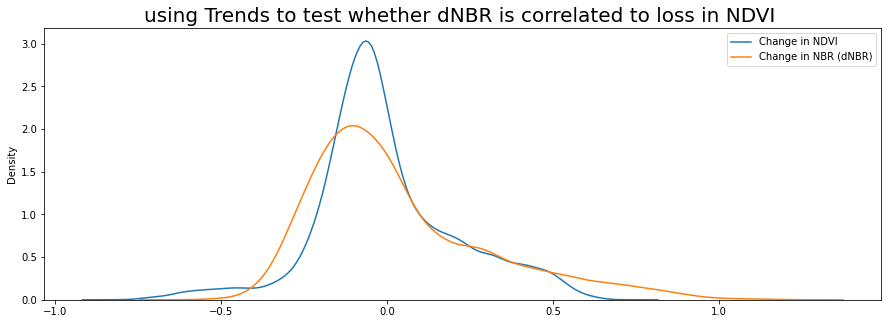

In [139]:
# Reproject the images and convert them to numpy array
image_1 = NDVI_diff.reproject(crs = ee.Projection('EPSG:4326'), scale =100)
data = np.array(image_1.sampleRectangle(region=area, defaultValue =0).get('ndvi').getInfo())

image_2 = dNBR.reproject(crs = ee.Projection('EPSG:4326'), scale =100)
data_2 = np.array(image_2.sampleRectangle(region=area, defaultValue =0).get('nbr').getInfo())

# first, we flatten our array to a 1-d array for the plot
ndvi= data.flatten()
dnbr = data_2.flatten()

# Plot the figure and axes
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(ndvi,label='Change in NDVI',legend=True, ax=ax)
sns.kdeplot(dnbr,label='Change in NBR (dNBR)',legend=True, ax=ax)
plt.legend(fontsize=10)
plt.title('using Trends to test whether dNBR is correlated to loss in NDVI ', fontsize=20);

### Was the Dixie fire uniform or did it affect some areas in different ways?

The Dixie Fire is uniform, it affected all area in the same way, it has a clustered pattern where all the fire spread out from a point to other point and keep spreading, a section of the forest was burned and everthing surround it was affeccted before the fire was fully contained.

## References
https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

https://developers.google.com/earth-engine/apidocs

https://geemap.org/notebooks/00_geemap_key_features/

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/nbr/